In [0]:
%tensorflow_version 1.x

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [0]:
url = "https://raw.githubusercontent.com/dranzerblaze/covid_19_analysis/master/covid_dataset.csv"
df = pd.read_csv(url)
df.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0,0.0,0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0,0.0,0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0,0.0,0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0,0.0,0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0,0.0,0


In [0]:
df = df.drop(['Province/State','Date'],axis=1)
df.head()

,Country/Region,Lat,Long,Confirmed,Recovered,Deaths
0,Afghanistan,33.0,65.0,0,0.0,0
1,Afghanistan,33.0,65.0,0,0.0,0
2,Afghanistan,33.0,65.0,0,0.0,0
3,Afghanistan,33.0,65.0,0,0.0,0
4,Afghanistan,33.0,65.0,0,0.0,0


In [0]:
df = df.rename(columns= {'Country/Region':'country'})
df_new = pd.get_dummies(df)
df_new.head()

,Lat,Long,Confirmed,Recovered,Deaths,country_Afghanistan,country_Albania,country_Algeria,country_Andorra,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bhutan,country_Bolivia,country_Bosnia and Herzegovina,country_Brazil,country_Brunei,country_Bulgaria,country_Burkina Faso,country_Burma,country_Cabo Verde,country_Cambodia,country_Cameroon,country_Canada,country_Central African Republic,country_Chad,country_Chile,country_China,...,country_Saint Kitts and Nevis,country_Saint Lucia,country_Saint Vincent and the Grenadines,country_San Marino,country_Saudi Arabia,country_Senegal,country_Serbia,country_Seychelles,country_Singapore,country_Slovakia,country_Slovenia,country_Somalia,country_South Africa,country_Spain,country_Sri Lanka,country_Sudan,country_Suriname,country_Sweden,country_Switzerland,country_Syria,country_Taiwan*,country_Tanzania,country_Thailand,country_Timor-Leste,country_Togo,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_US,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_West Bank and Gaza,country_Zambia,country_Zimbabwe
0,33.0,65.0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33.0,65.0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,33.0,65.0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,33.0,65.0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,33.0,65.0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
supervised_data = series_to_supervised(df_new,1,1)
supervised_data.shape

(15439, 362)

In [0]:
values = supervised_data.values 
n_train_time = 60
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(60, 1, 361) (60,) (15379, 1, 361) (15379,)


In [0]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 60 samples, validate on 15379 samples
Epoch 1/50
 - 2s - loss: 0.0901 - val_loss: 0.2110
Epoch 2/50
 - 1s - loss: 0.1066 - val_loss: 0.1895
Epoch 3/50
 - 1s - loss: 0.0943 - val_loss: 0.1850
Epoch 4/50
 - 1s - loss: 0.0829 - val_loss: 0.1903
Epoch 5/50
 - 1s - loss: 0.0604 - val_loss: 0.1974
Epoch 6/50
 - 1s - loss: 0.0711 - val_loss: 0.2024
Epoch 7/50
 - 1s - loss: 0.0610 - val_loss: 0.2048
Epoch 8/50
 - 1s - loss: 0.0802 - val_loss: 0.1991
Epoch 9/50
 - 1s - loss: 0.0698 - val_loss: 0.1904
Epoch 10/50
 - 1s - loss: 0.0614 - val_loss: 0.1855
Epoch 11/50
 - 1s - loss: 0.0965 - val_loss: 0.1800
Epoch 12/50
 - 1s - loss: 0.0562 - val_loss: 0.1767
Epoch 13/50
 - 1s - loss: 0.0461 - val_loss: 0.1755
Epoch 14/50
 - 1s - loss: 0.0519 - val_loss: 0.1727
Epoch 15/50
 - 1s - loss: 0.0673 - val_loss: 0.1694
Epoch 16/50
 - 1s - loss: 0.0413 - val_loss: 0.1680
Epoch 17/50
 - 1s - loss: 0.0421 - val_loss: 0.1685
Epoch 18/50
 - 1s - loss: 0.0531 - val_loss: 0.1690
Epoch 19/50
 - 1s - loss: 

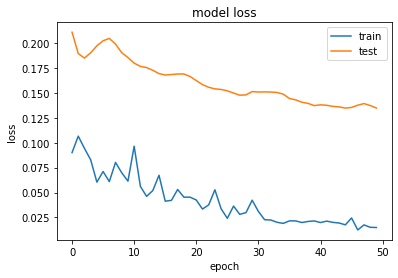

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()